<a href="https://colab.research.google.com/github/wanburana/AT82.01-brain-project-group-4/blob/main/Jirasak/code/cnnrnn_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing the paper [Emotion Recognition from Multi-Channel EEG through Parallel Convolutional Recurrent Neural Network](https://ieeexplore.ieee.org/document/8489331)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install mne
!gdown --id 1LoyiM9bQlrullvtoPA7X4FWhNDBGPnED # dataset
!unzip /content/data_preprocessed_python.zip -d data_preprocessed_python

!gdown --id 1sacOlggvbtn5ATVkrb3DJqfpSg7eI3Fo # label

     |████████████████████████████████| 7.4 MB 7.9 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1LoyiM9bQlrullvtoPA7X4FWhNDBGPnED
To: /content/data_preprocessed_python.zip
100% 3.30G/3.30G [00:23<00:00, 140MB/s]
Archive:  /content/data_preprocessed_python.zip
 extracting: data_preprocessed_python/s01.dat  
 extracting: data_preprocessed_python/s02.dat  
 extracting: data_preprocessed_python/s03.dat  
 extracting: data_preprocessed_python/s04.dat  
 extracting: data_preprocessed_python/s05.dat  
 extracting: data_preprocessed_python/s06.dat  
 extracting: data_preprocessed_python/s07.dat  
 extracting: data_preprocessed_python/s08.dat  
 extracting: data_preprocessed_python/s09.dat  
 extracting: data_preprocessed_python/s10.dat  
 extracting: data_preprocessed_python/s11.dat  
 extracting: data_preprocessed_python/s12.dat  
 extracting: data_preprocessed_python/s13.dat  
 extracting: data_preprocessed_python/s14.dat  
 extracting: data_preprocessed_python/s15.dat  
 extrac

In [2]:
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import mne
import pywt

import torch
from torch import nn

In [3]:
FOLDER_PATH = '/content/data_preprocessed_python/'
files_list = sorted(glob(FOLDER_PATH + '*'))

In [4]:
features = []
targets = []

for i, f in (enumerate(tqdm(files_list))):
    with open(f, 'rb') as f: 
        content = pickle.load(f, encoding='latin1')
        data = content['data']
        labels = content['labels']
        
        n_clips, n_channels, len_features = data.shape
        
        for j in range(n_clips):
            features.append(data[j])
            targets.append(labels[j])

features = np.array(features) 
targets = np.array(targets)     

eeg_features = features[:, :32, :] # use only eeg channels
print(eeg_features.shape)

100%|██████████| 32/32 [00:04<00:00,  7.51it/s]


(1280, 32, 8064)


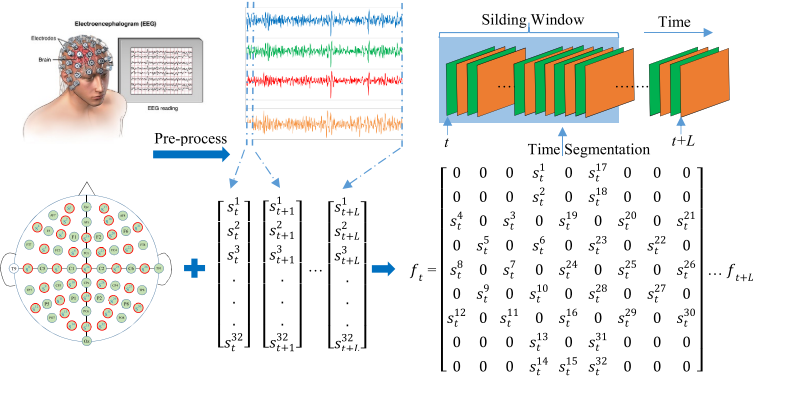

In [5]:
# util function
def create_2d_spatial_array(sample):
    '''
    Convert The data from 32*seq_len -> 9*9*seq_len
    '''
    seq_len = sample.shape[-1]
    matrix_2d = np.array([
                    [np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),     sample[0],     np.zeros(seq_len),     sample[16],     np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),],
                    [np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),     sample[1],     np.zeros(seq_len),     sample[17],     np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),],
                    [sample[3],  np.zeros(seq_len),  sample[2],        np.zeros(seq_len), sample[18],         np.zeros(seq_len), sample[19],     np.zeros(seq_len), sample[20],],
                    [np.zeros(seq_len),  sample[4],     np.zeros(seq_len),     sample[5],     np.zeros(seq_len),     sample[22],     np.zeros(seq_len), sample[21],     np.zeros(seq_len),],
                    [sample[7],  np.zeros(seq_len),  sample[6],        np.zeros(seq_len), sample[23],         np.zeros(seq_len),  sample[24],    np.zeros(seq_len), sample[25],],
                    [np.zeros(seq_len),  sample[8],     np.zeros(seq_len),     sample[9],     np.zeros(seq_len),     sample[27],     np.zeros(seq_len), sample[26],     np.zeros(seq_len),],
                    [sample[11], np.zeros(seq_len), sample[10],        np.zeros(seq_len), sample[15],         np.zeros(seq_len), sample[28],     np.zeros(seq_len), sample[29],],
                    [np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),    sample[12],     np.zeros(seq_len),     sample[30],     np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),],
                    [np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),    sample[13], sample[14],     sample[31],     np.zeros(seq_len),     np.zeros(seq_len),     np.zeros(seq_len),]
                    ])
    
    return matrix_2d

def vectorized_windowing(arr, window_len, overlap_len=None):
    '''
    Sliding window without using loop
    '''
    seq_len = arr.shape[-1]
    
    if not overlap_len:
        overlap_len = window_len

    n_sliding_windows = ((seq_len - window_len) // overlap_len) + 1

    sub_windows = np.array([np.arange(window_len)]) + np.array([np.arange(n_sliding_windows) * overlap_len]).T

    slided_arr = arr[..., sub_windows]

    return slided_arr

def remove_baseline(sample, baseline_normalize=True, sampling_rate=128):
    """
    Remove baseline, with an option to use that baseline to normalize the rest of the data
    """
    baseline_len = sampling_rate * 3

    baseline, new_sample = np.split(sample, indices_or_sections=[baseline_len], axis=1)
    if baseline_normalize:
        baseline_1s = np.split(baseline, indices_or_sections=baseline_len//sampling_rate, axis=1)
        baseline_1s_mean = np.mean(baseline_1s, axis=0)

        new_sample = new_sample - np.tile(baseline_1s_mean, reps=60)
    
    return new_sample

def standardize_across_channel(sample):
    """
    Standardize the data across all channel
    """
    
    mu = sample.mean(axis=0)
    sigma = sample.std(axis=0)
    sample_standardized = (sample - mu) / sigma

    return sample_standardized

In [15]:
root_path = '/content/drive/MyDrive/AT82.01/CP Project Group 4/Jirasak'

cnn_filename = 'eeg_preprocessed_cnn_memmap.dat'
cnn_fp = np.memmap(f'{root_path}/{cnn_filename}', dtype='float32', mode='w+', shape=(1280, 60, 9, 9, 128))

rnn_filename = 'eeg_preprocessed_rnn_memmap.dat'
rnn_fp = np.memmap(f'{root_path}/{rnn_filename}', dtype='float32', mode='w+', shape=(1280, 60, 32, 128))

for ii, sample in enumerate(tqdm(eeg_features)):
    sample_baseline_removed = remove_baseline(sample)
    sample_standardized = standardize_across_channel(sample_baseline_removed)

    # CNN preprocess
    sample_2d = create_2d_spatial_array(sample_standardized)
    sample_2d_segmented = vectorized_windowing(sample_2d, window_len=128)
    sample_2d_segmented_moveaxis = np.moveaxis(sample_2d_segmented, len(sample_2d_segmented.shape)-2, 0).astype('float32')
    cnn_fp[ii] = sample_2d_segmented_moveaxis

    # RNN preprocess
    sample_segmented = vectorized_windowing(sample_standardized, window_len=128)
    sample_segmented_moveaxis = np.moveaxis(sample_segmented, len(sample_segmented.shape)-2, 0).astype('float32')
    rnn_fp[ii] = sample_segmented_moveaxis


cnn_fp.flush()   
rnn_fp.flush()

100%|██████████| 1280/1280 [00:43<00:00, 29.64it/s]


In [8]:
numpy_pretty_print = np.printoptions(edgeitems=9,
                                     linewidth=100000, 
                                     suppress=True, 
                                     precision=3)

with numpy_pretty_print:
    print(sample_2d_segmented_moveaxis[0,:,:,0])

[[ 0.     0.     0.    -0.607  0.    -0.046  0.     0.     0.   ]
 [ 0.     0.     0.    -1.75   0.    -1.215  0.     0.     0.   ]
 [-1.883  0.    -0.703  0.    -0.13   0.     0.058  0.    -0.622]
 [ 0.    -0.193  0.    -0.141  0.    -2.393  0.    -1.155  0.   ]
 [-0.722  0.     0.422  0.     0.168  0.     1.2    0.    -0.842]
 [ 0.     1.175  0.     0.462  0.     1.177  0.     2.044  0.   ]
 [ 0.671  0.     0.246  0.     0.483  0.     1.205  0.     0.052]
 [ 0.     0.     0.     0.269  0.     1.636  0.     0.     0.   ]
 [ 0.     0.     0.     0.43   0.11   0.593  0.     0.     0.   ]]
